In [2]:
import pandas as pd

In [3]:
data = pd.read_csv('data.csv')
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1240,0.067,0.035016,-7.268846,0,0.010,0.049516,-5.369901,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,0.002,0.054298,-2.657477,269,0.004,0.031942,-4.449220,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,2,0.014,0.014096,-3.824875,21,0.014,0.014906,-3.939309,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,0,1,1,3,0.012,0.015232,-3.461357,99,0.006,0.050671,-3.418403,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,0,1,0,4,0.019,0.051265,-4.009026,11464230,6.790,0.032005,-2.828797,1,1


In [4]:
# удалим лишние колонки
data = data.drop(columns = ['banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1'])

<Axes: xlabel='campaign_clicks'>

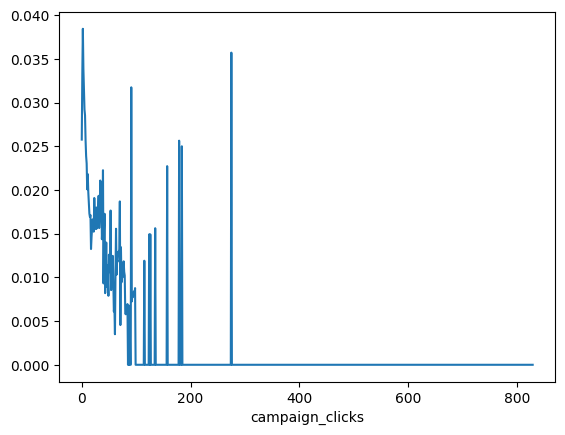

In [19]:
import matplotlib.pyplot as plt
data.groupby('campaign_clicks')['clicks'].mean().plot()


Ненулевое количество кликов только для наблюдений с campaign_clicks < 250 (примерно)

In [5]:
data['before_clicks'] = data['campaign_clicks'] > 250
data['before_clicks'] = data['before_clicks'].astype(int)

In [46]:
data['before_clicks'].sum()

5457

In [24]:
data['os_id'].value_counts()

os_id
2     4589979
0     3856798
1     3178693
4     3012541
3      759767
6      310346
5      111946
8        1273
7          99
9          25
10          5
Name: count, dtype: int64

Редкие группы присоединим к ближайшим по среднему числу кликов

In [23]:
data.groupby('os_id')['clicks'].mean()

os_id
0     0.030062
1     0.013518
2     0.017832
3     0.048044
4     0.039583
5     0.053302
6     0.063603
7     0.030303
8     0.024352
9     0.000000
10    0.000000
Name: clicks, dtype: float64

In [6]:
#9 10 c 2 
# 7 8 c 0
data['os_id'] = data['os_id'].replace({9: 2, 10: 2, 7: 0, 8: 0})

In [29]:
print('unique users:', data['oaid_hash'].nunique())
print('unique banners:', data['banner_id'].nunique())

unique users: 6510316
unique banners: 1633


In [7]:
from sklearn.preprocessing import OneHotEncoder

Остальное как в прошлом дз, но не удаляем айди юзера и баннера

In [8]:
   # удаляем impressions
data = data.drop('impressions', axis = 1)

# создаем фичи от времени
data.date_time = pd.to_datetime(data.date_time)
data['day'] = data['date_time'].dt.weekday
data['hour'] = data['date_time'].dt.hour

# добавляем интерсекции между часом и днем недели 
data['hour_day'] = data['day'].astype(str) + ' ' + data['hour'].astype(str)
data['hour_day'] = pd.factorize(data['hour_day'])[0]

# выделяем редкие zone id в категорию -1
zone_id_counts = data['zone_id'].value_counts()
idxs = zone_id_counts[zone_id_counts < 10].index

data.loc[data['zone_id'].isin(idxs), 'zone_id'] = -1

# делим выборку на train и test
data = data.sort_values(by='date_time', ignore_index=True)
cut_off_val = data[data['date_time'] < pd.to_datetime('2021-10-01')].index[-1]
cut_off_test = data[data['date_time'] < pd.to_datetime('2021-10-02')].index[-1]

y = data['clicks']
data = data.drop(columns = ['clicks', 'campaign_clicks', 'date_time'])
data_train, data_test = data.iloc[:cut_off_test, :], data.iloc[cut_off_test:, :]
y_train_all, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]

# делаем one hot encodings
enc = OneHotEncoder(drop='first', handle_unknown='ignore')
enc.fit(data_train)
transformed_train_all = enc.transform(data_train)
transformed_test = enc.transform(data_test)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1, 2, 6, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [9]:
transformed_train, transformed_val = transformed_train_all[:cut_off_val], transformed_train_all[cut_off_val:]
y_train, y_val = y_train_all[:cut_off_val], y_train_all[cut_off_val:]

In [1]:
!pip install xlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 2.7 MB/s eta 0:00:0000:0100:010m
  Preparing metadata (setup.py) ... done
  Created wheel for xlearn: filename=xlearn-0.40a1-py3-none-any.whl size=145455 sha256=20a8964e2c0de3ec94aa9cfb9ccca1a554cf1a9c430a994d46fb87dc3c4c974e
  Stored in directory: /Users/mariamitrankova/Library/Caches/pip/wheels/1c/11/3b/df8413edafafa96e8eddf2ca22ff15a19ceb6b5f9b9a28e443
Successfully built xlearn


In [10]:
import xlearn as xl
import numpy as np

In [11]:
fields = []
for i, col in enumerate(data_train.columns):
    fields += [i]*len(data_train[col].unique())
fields = np.array(fields)
fields

array([0, 0, 0, ..., 8, 8, 8])

In [12]:
from tqdm import tqdm 

def convert_to_libffm(X, labels, file):
    row_idx, col_idx = X.nonzero()
    values = X.data
    with open(file, "w") as file:
        file.write(f"{labels[row_idx[0]]}")
        file.write(f' {fields[col_idx[0]]}:{col_idx[0]}:{values[0]}')
        for i in tqdm(range(1, len(row_idx))):
            if row_idx[i] == row_idx[i-1]:
                file.write(f' {fields[col_idx[i]]}:{col_idx[i]}:{values[i]}')
            else:
                file.write('\n')
                file.write(f'{labels[row_idx[i]]}')
                file.write(f' {fields[col_idx[i]]}:{col_idx[i]}:{values[i]}')

In [13]:
convert_to_libffm(transformed_train, y_train, 'train.txt')

100%|██████████████████████████████████████████████████████████████████| 86863321/86863321 [05:26<00:00, 265766.64it/s]


In [14]:
convert_to_libffm(transformed_val, y_val.values, 'val.txt')
convert_to_libffm(transformed_test, y_test.values, 'test.txt')

100%|████████████████████████████████████████████████████████████████████| 9835764/9835764 [00:32<00:00, 304962.18it/s]


In [15]:
ffm_model = xl.create_ffm() 
ffm_model.setTrain("train.txt")

In [16]:
param = {'task':'binary', 'lr':0.2, 'lambda':0.002, 'k': 4, 'epoch' : 10, 'metric': 'auc'}
ffm_model.fit(param, "model_default.out")

In [18]:
from sklearn.metrics import roc_auc_score, log_loss

In [19]:
ffm_model.setSigmoid()
ffm_model.setTest("val.txt")
pred = ffm_model.predict("model_default.out")
print(f"auc: {roc_auc_score(y_val, pred)}")
print(f"log_loss: {log_loss(y_val, pred)}")

auc: 0.7898091290479862
log_loss: 0.15592709130561022


In [20]:
# бейзлайн
pred = np.ones_like(y_test) * y_test.mean()
print(f"auc: {roc_auc_score(y_test, pred)}")
print(f"log_loss: {log_loss(y_test, pred)}")

Test Baseline:
auc: 0.5
log_loss: 0.15303284409655607


In [21]:
# метрики
ffm_model.setSigmoid()
ffm_model.setTest("test.txt")
pred = ffm_model.predict("model_default.out")
print(f"test auc: {roc_auc_score(y_test, pred)}")
print(f"test log_loss: {log_loss(y_test, pred)}")

test auc: 0.7768808920288568
test log_loss: 0.13678437330644386
